# 1. Checking Images, Cropping, and Making Color RGB Images

This notebook borrows heavily from tutorials made by Aabdurro'uf, see https://github.com/aabdurrouf/ivcitb2022

In this first step we will be using data from Panoramic-JWST, making crops, perform point spread function (PSF) matching, and create a color RGB image. 

Information on the set of imaging filters in NIRCam instrument: https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters

In [5]:

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

List the input imagig data along with the filter names

In [6]:
# list of filters and their names
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']

filters = ['f115w', 'f150w', 'f200w', 'f277w','f356w', 'f444w']

# number of filters
nbands = len(filters)

# data directory
data_dir = './data/'



## 1.1. Checking Images and Cropping

Due to the inhomogeneity of imaging coverage among NIRcam filters (as shown below) and to reduce the memory usage, we will crop the original image. We will make two cropped regions. 

### Crop region

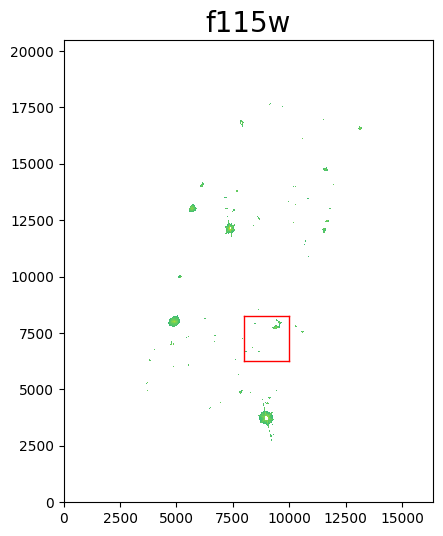

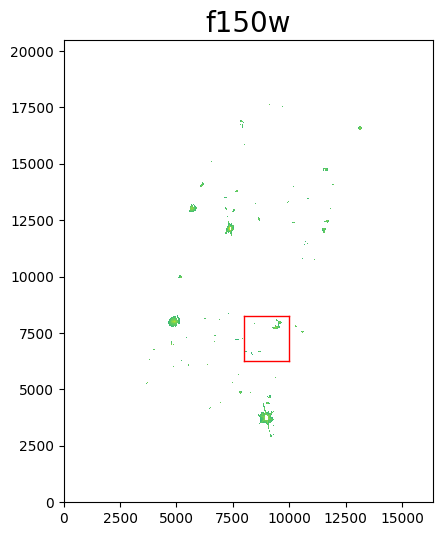

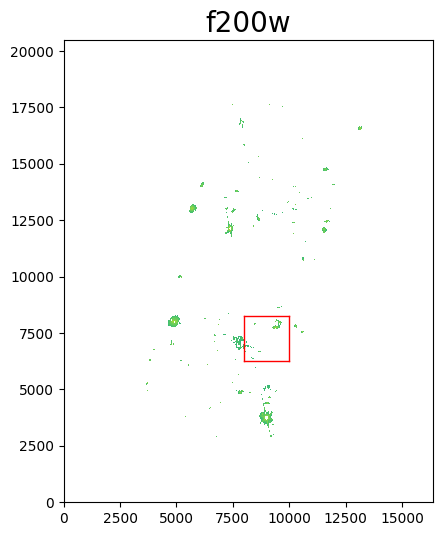

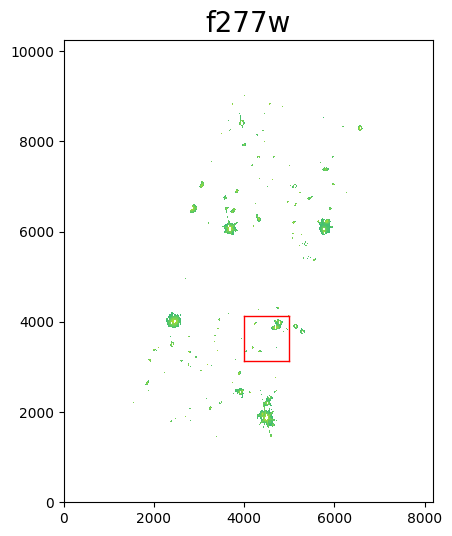

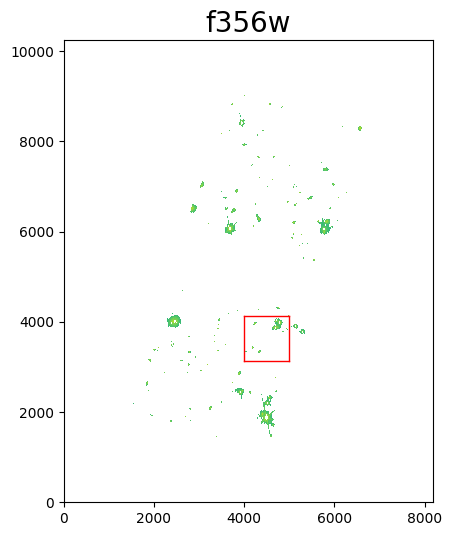

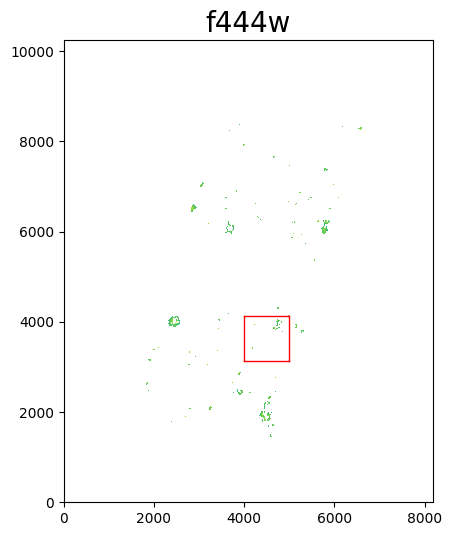

In [7]:
file_prefix='panoramic-j221700p0025-v7.2-'
file_suffix_sci='-clear_drc_sci.fits.gz'
file_suffix_wht='-clear_drc_wht.fits.gz'

immult=[2.0,2.0,2.0,1.0,1.0,1.0]   #  images in shorter wavelength bands have 2x sampling in pixels

for i in range(0,nbands):
    sci_name=file_prefix+filters[i]+file_suffix_sci
    hdu = fits.open(data_dir+sci_name)
    data_img = hdu[0].data
    hdu.close()
    
    fig1 = plt.figure(figsize=(12,6))
    f1 = plt.subplot()
    plt.title('%s' % filters[i], fontsize=20)
    plt.imshow(np.log10(data_img), origin='lower')
    
    # Boundary of the area to be cropped
    xmin, xmax = 4000, 5000
    ymin, ymax = 3130, 4130
    
    x = np.linspace(xmin*immult[i],xmax*immult[i],100)
    y = ymin*immult[i] + x - x
    plt.plot(x,y,lw=1,color='red')
    y = ymax*immult[i] + x - x
    plt.plot(x,y,lw=1,color='red')
    
    y = np.linspace(ymin*immult[i],ymax*immult[i],100)
    x = xmin*immult[i] + y - y
    plt.plot(x,y,lw=1,color='red')
    x = xmax*immult[i] + y - y
    plt.plot(x,y,lw=1,color='red')
    plt.show()

In [8]:
x_cent, y_cent = xmin+(0.5*(xmax-xmin)), ymin+(0.5*(ymax-ymin))
print (x_cent, y_cent)
crop_size = np.array([ymax-ymin+1, xmax-xmin+1])
print (crop_size)

4500.0 3630.0
[1001 1001]


To crop FITS file images, we can use [Cutout2D](https://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html) function from [astropy](https://www.astropy.org/) package. This funciton will retain the World Coordinate System information in the cropped images. In addition to cropping, we will produce variance images, which are the square of uncertainty images.

In [9]:
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

for i in range(0,nbands):
    
    # crop science image
    sci_name=file_prefix+filters[i]+file_suffix_sci
    hdu = fits.open(data_dir+sci_name)[0]
    wcs = WCS(hdu.header)
    position = np.array([x_cent,y_cent])
    cutout = Cutout2D(hdu.data, position=position*immult[i], size=crop_size*immult[i], wcs=wcs)
    name_out = 'crop1_%s' % sci_name
    fits.writeto(name_out, cutout.data, cutout.wcs.to_header(), overwrite=True)
    print ("[produce %s]" % name_out)
    
    # crop weight image

    wht_name=file_prefix+filters[i]+file_suffix_wht
    hdu = fits.open(data_dir+wht_name)[0]
    wcs = WCS(hdu.header)
    position = np.array([x_cent,y_cent])
    cutout = Cutout2D(hdu.data, position=position*immult[i], size=crop_size*immult[i], wcs=wcs)
    name_out = 'crop1_weight_%s' % wht_name
    fits.writeto(name_out, cutout.data, cutout.wcs.to_header(), overwrite=True)
    print ("[produce %s]" % name_out)

[produce crop1_panoramic-j221700p0025-v7.2-f115w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f115w-clear_drc_wht.fits.gz]
[produce crop1_panoramic-j221700p0025-v7.2-f150w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f150w-clear_drc_wht.fits.gz]
[produce crop1_panoramic-j221700p0025-v7.2-f200w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f200w-clear_drc_wht.fits.gz]
[produce crop1_panoramic-j221700p0025-v7.2-f277w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f277w-clear_drc_wht.fits.gz]
[produce crop1_panoramic-j221700p0025-v7.2-f356w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f356w-clear_drc_wht.fits.gz]
[produce crop1_panoramic-j221700p0025-v7.2-f444w-clear_drc_sci.fits.gz]
[produce crop1_weight_panoramic-j221700p0025-v7.2-f444w-clear_drc_wht.fits.gz]


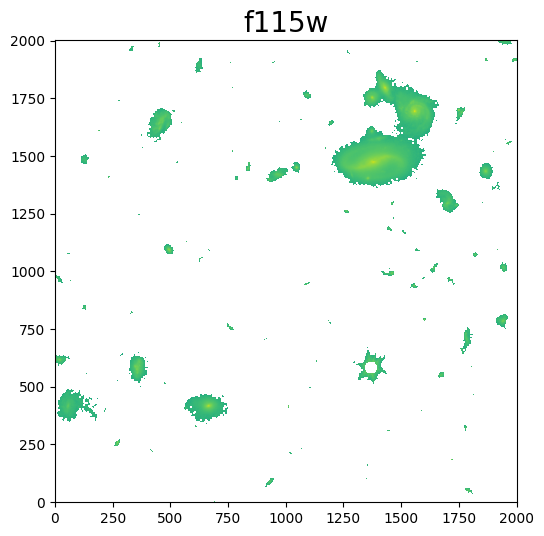

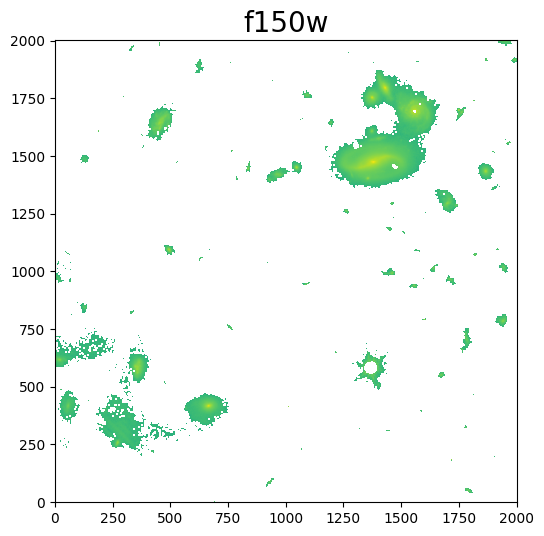

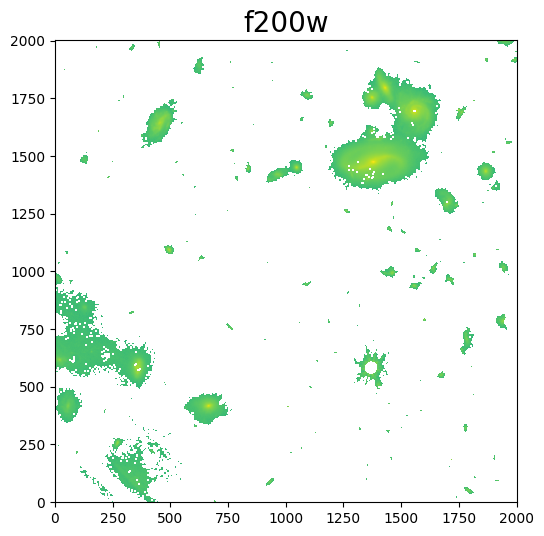

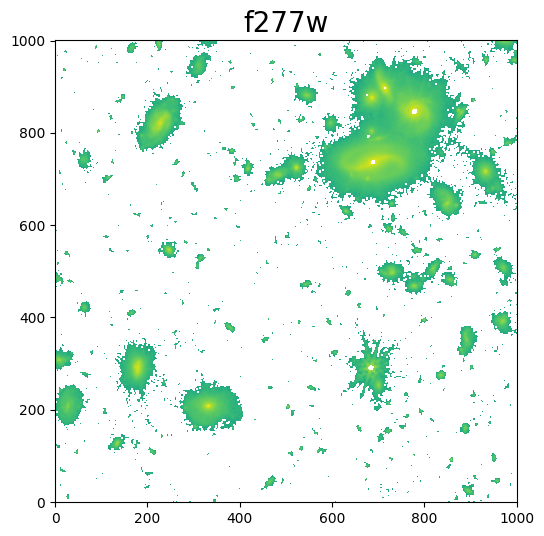

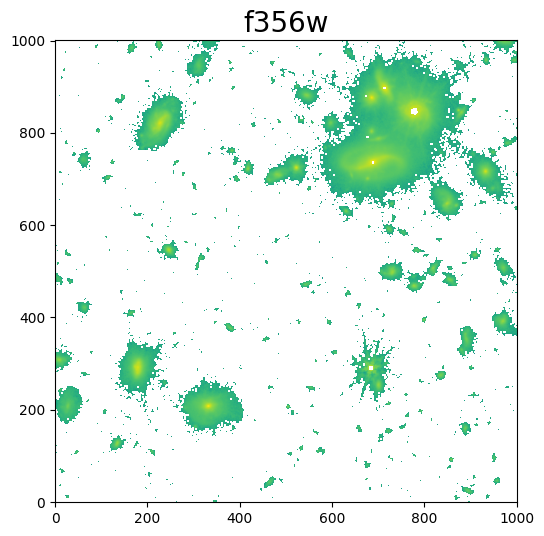

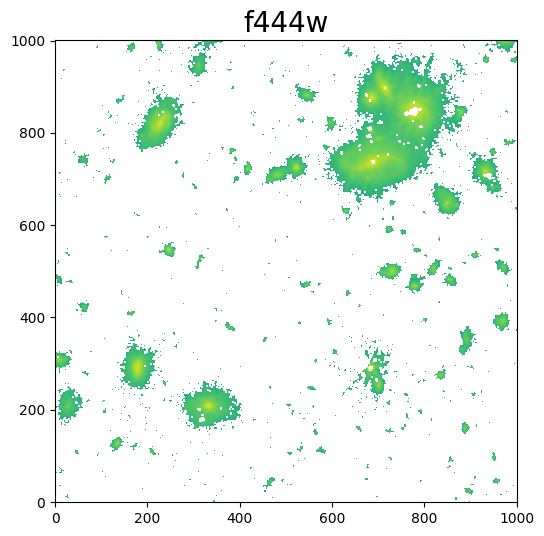

In [10]:
# check cropped science images
for i in range(0,nbands):
    sci_name=file_prefix+filters[i]+file_suffix_sci
    hdu = fits.open('crop1_%s' % sci_name)
    data_img = hdu[0].data
    hdu.close()
    
    fig1 = plt.figure(figsize=(12,6))
    f1 = plt.subplot()
    plt.title('%s' % filters[i], fontsize=20)
    plt.imshow(np.log10(data_img), origin='lower')
    plt.show()

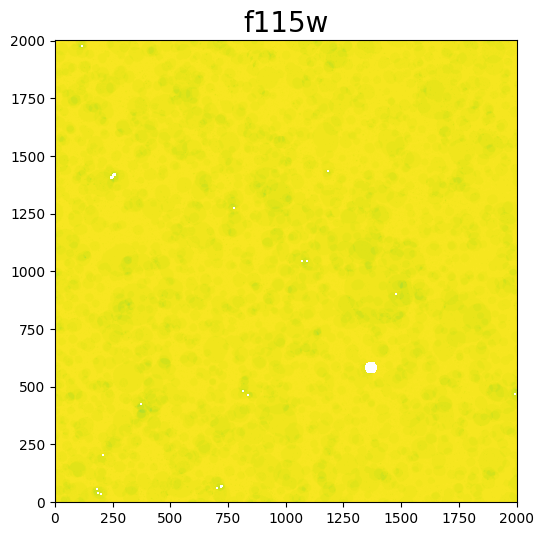

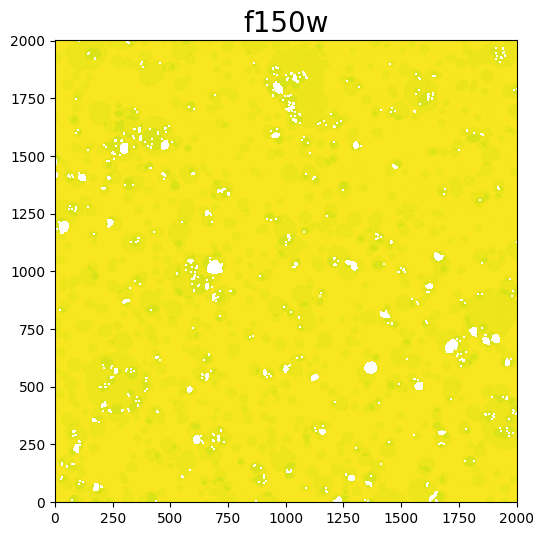

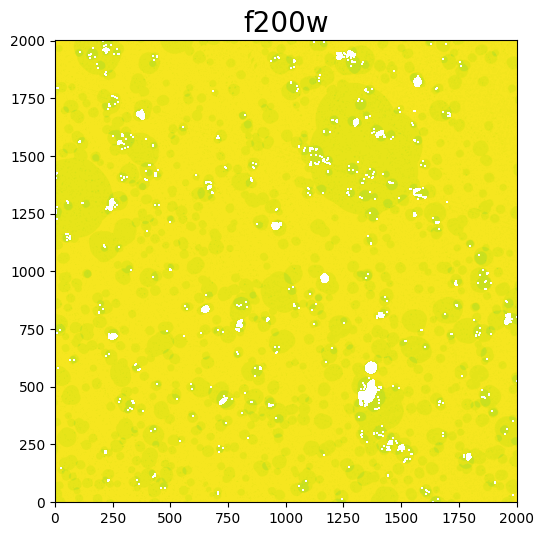

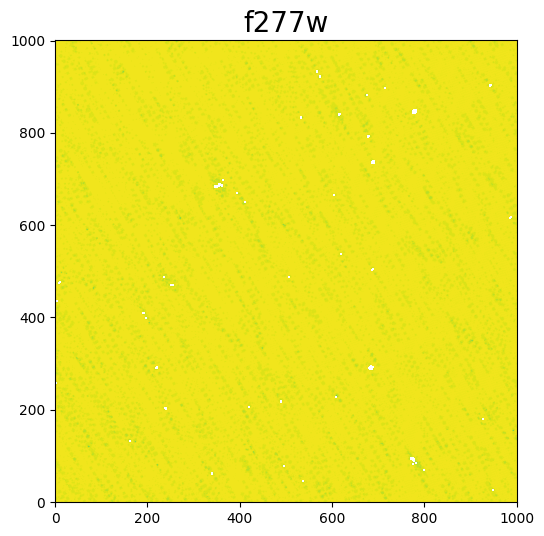

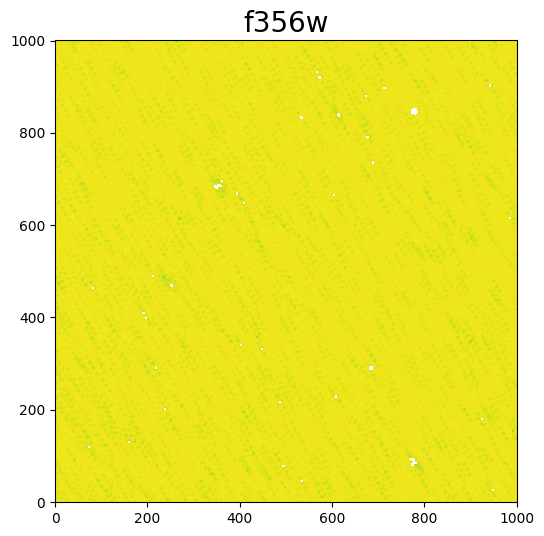

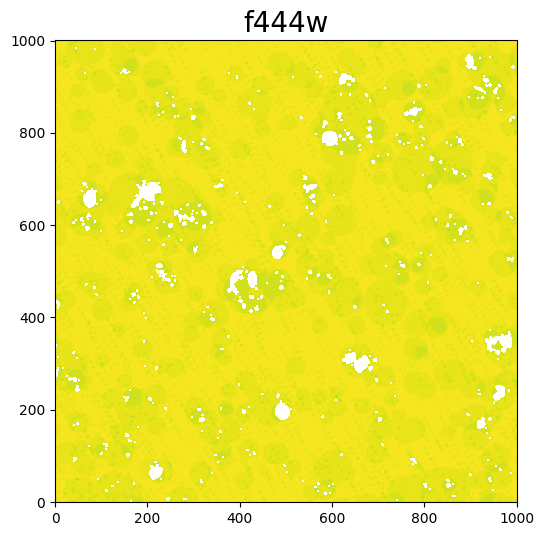

In [11]:
# check cropped variance image
for i in range(0,nbands):
    wht_name=file_prefix+filters[i]+file_suffix_wht
    hdu = fits.open('crop1_weight_%s' % wht_name)
    data_img = hdu[0].data
    hdu.close()
    
    fig1 = plt.figure(figsize=(12,6))
    f1 = plt.subplot()
    plt.title('%s' % filters[i], fontsize=20)
    plt.imshow(np.log10(data_img), origin='lower')
    plt.show()

## 1.2. PSF matching to match spatial resolution of F444W band

The PSF (point spread function or spatial resolution) size varies among filters. Before proceeding further with the aperture photometry, we need to bring all the images into the same spatial resolution. In this step, we will do PSF matching, which is a process of matching spatial resolution of multiband images.

PSF characteristics of NIRCam instrument: https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions

Commonly, PSF matching is done by convolving images with pre-calculated kernels. The kernels are calculated from model or empirical PSFs of the cameras. In this tutorial, we will be using kernels from https://www.astro.princeton.edu/~draine/Kernels/Kernels_JWST/Kernels_fits_Files/Hi_Resolution/ which were calculated using a technique described in [Aniano et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011PASP..123.1218A/abstract).

Model PSFs of NIRcam: https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions

In case you don't have kernels and you need to calculate (generate) them from PSF images, you can use Photutils package and follow this instruction: https://photutils.readthedocs.io/en/stable/psf_matching.html#module-photutils.psf.matching

In [12]:
# list of pre-calculated convolution kernels
dir_kernel = "kernels/"
kernels = ['Kernel_HiRes_JWST_NIRCam_F115W_to_JWST_NIRCam_F444W.fits.gz',
           'Kernel_HiRes_JWST_NIRCam_F150W_to_JWST_NIRCam_F444W.fits.gz',
           'Kernel_HiRes_JWST_NIRCam_F200W_to_JWST_NIRCam_F444W.fits.gz',
           'Kernel_HiRes_JWST_NIRCam_F277W_to_JWST_NIRCam_F444W.fits.gz',
           'Kernel_HiRes_JWST_NIRCam_F356W_to_JWST_NIRCam_F444W.fits.gz']

We would do PSF matching to both science and variance images in both cropped region 1 and 2. We will use [convolve_fft](https://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html) function for this. Before we can use this function, we need to resize our kernels, to have the same pixel size as the imaging data.

Note: **Panoramic pixel sizes are 0.02 arcsec/pixel and 0.04 arcsec/pixel**.

### PSF matching for the cropped region 1

In [15]:
!pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:0100:01
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [16]:
from astropy.convolution import convolve_fft
from photutils.psf.matching import resize_psf


for bb in range(0,nbands-1):
    # get kernel data
    
    hdu = fits.open(dir_kernel+kernels[bb])
    kernel_data = hdu[0].data
    pixscale = hdu[0].header['CD1_1']*3600.0
    hdu.close()

    # pixel size of Panoramic images
    pixsize = 0.02*immult[i]  # 0.02 or 0.04 arcsec/pixel
    
    
    # resize kernel
    kernel_resize = resize_psf(kernel_data, pixscale, pixsize, order=3)
    
    #==> science image
    crop_sci_name='crop1_%s' % file_prefix+filters[bb]+file_suffix_sci

#    name = 'crop1_%s' % sci_img[bb]
    hdu = fits.open(crop_sci_name)
    data_img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    # PSF matching
    psfmatch_data_img = convolve_fft(data_img, kernel_resize, allow_huge=True)
    # write to FITS file
    name_out = 'psfmatch_%s' % crop_sci_name
    fits.writeto(name_out, psfmatch_data_img, header, overwrite=True)
        
    crop_wht_name='crop1_weight_%s' % file_prefix+filters[bb]+file_suffix_wht       
        
    #==> variance image
    hdu = fits.open(crop_wht_name)
    data_img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    # PSF matching
    psfmatch_data_img = convolve_fft(data_img, kernel_resize, allow_huge=True)
    # write to FITS file
    name_out = 'psfmatch_%s' % crop_wht_name
    fits.writeto(name_out, psfmatch_data_img, header, overwrite=True)


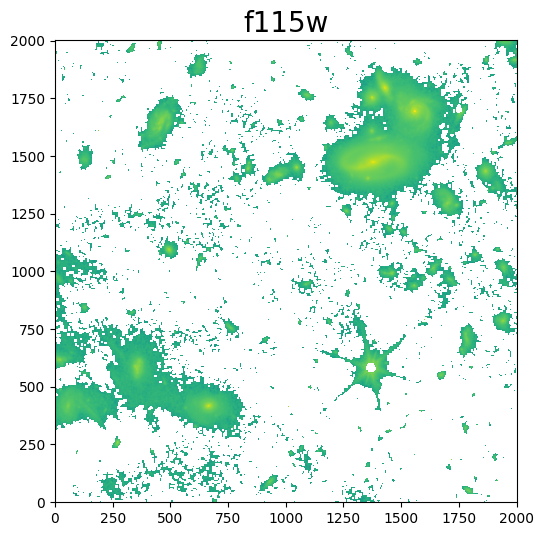

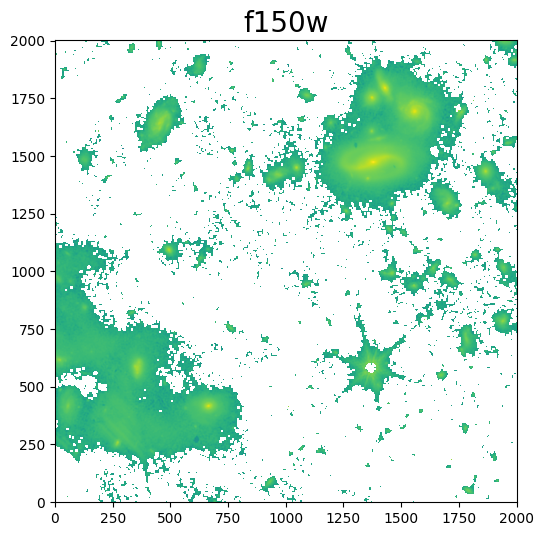

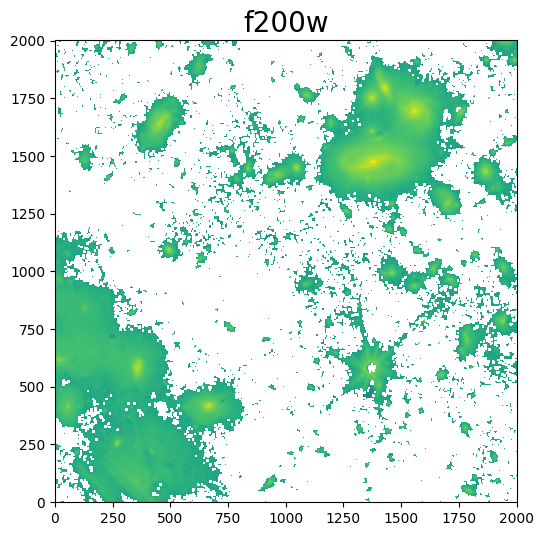

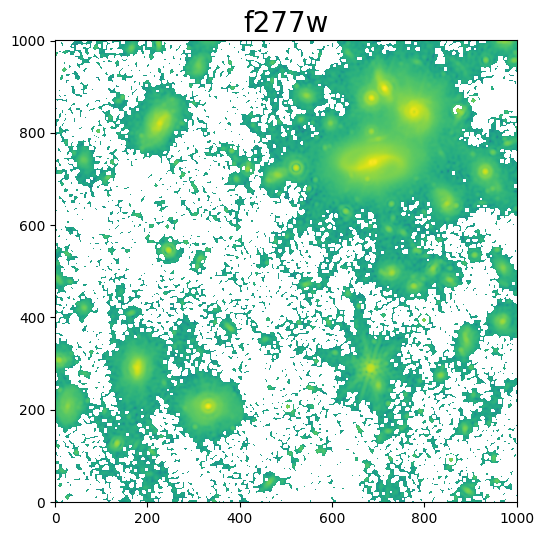

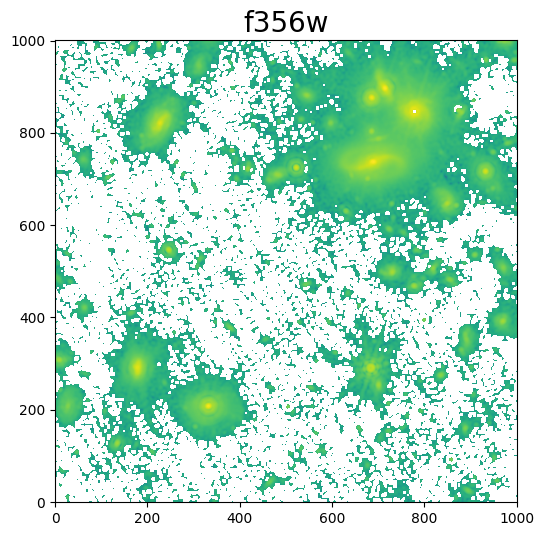

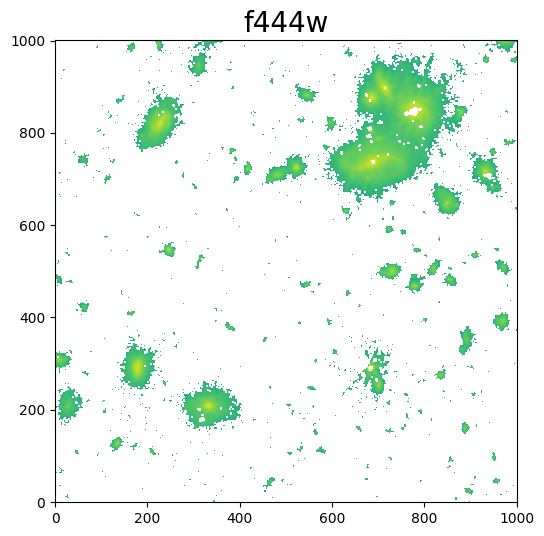

In [17]:
# check science image after PSF matching
for bb in range(0,nbands):
    

    if bb < nbands-1:
        name='psfmatch_crop1_%s' % file_prefix+filters[bb]+file_suffix_sci    
    else:
        name='crop1_%s' % file_prefix+filters[bb]+file_suffix_sci    
    hdu = fits.open(name)
    data_img = hdu[0].data
    hdu.close()
    
    fig1 = plt.figure(figsize=(12,6))
    f1 = plt.subplot()
    plt.title('%s' % filters[bb], fontsize=20)
    plt.imshow(np.log10(data_img), origin='lower')

## 1.3. Make RGB color image

This is an optional step and not related to aperture photometry. A color image gives a visual impression to the astronomical images. For this, we will use [make_lupton_rgb](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html) function from the astropy package.

### Make RGB color image for cropped region

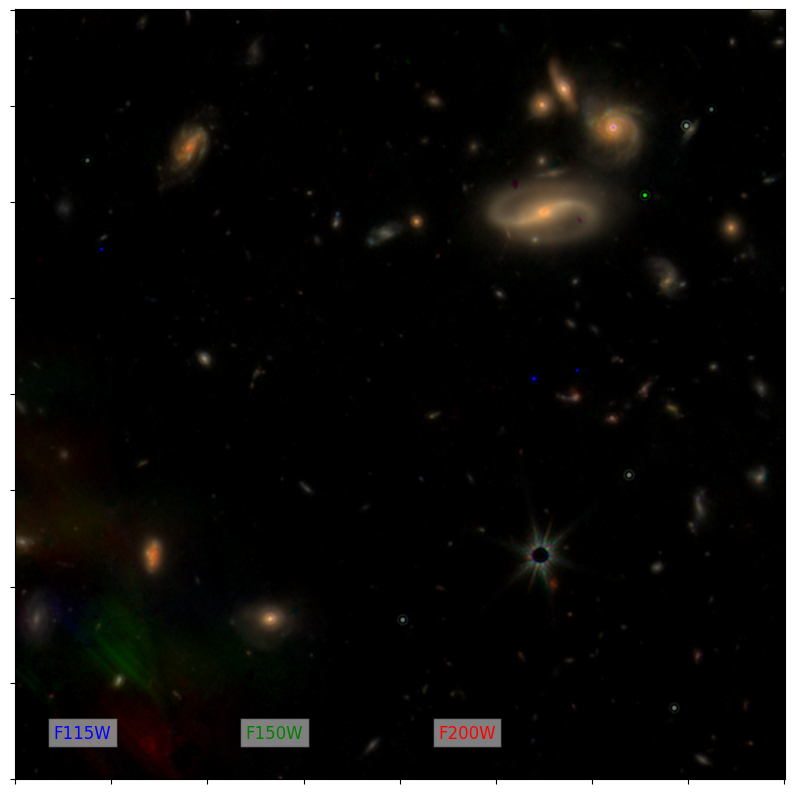

In [18]:
from astropy.visualization import make_lupton_rgb

b = 'psfmatch_crop1_panoramic-j221700p0025-v7.2-f115w-clear_drc_sci.fits.gz'
g = 'psfmatch_crop1_panoramic-j221700p0025-v7.2-f150w-clear_drc_sci.fits.gz'
r = 'psfmatch_crop1_panoramic-j221700p0025-v7.2-f200w-clear_drc_sci.fits.gz'

hdu = fits.open(b)
blue = hdu[0].data
hdu.close()

hdu = fits.open(g)
green = hdu[0].data
hdu.close()

hdu = fits.open(r)
red = hdu[0].data
hdu.close()

rgb = make_lupton_rgb(red, green, blue, Q=10, stretch=0.25)

fig = plt.figure(figsize=(10,10))
f1 = plt.subplot()
plt.setp(f1.get_yticklabels(), visible=False)
plt.setp(f1.get_xticklabels(), visible=False)
plt.imshow(rgb, origin='lower')

f1.text(0.05, 0.06, 'F115W', horizontalalignment='left', verticalalignment='center',
            transform = f1.transAxes, fontsize=12, color='blue',
       bbox = dict(facecolor ='white', alpha = 0.5))

f1.text(0.3, 0.06, 'F150W', horizontalalignment='left', verticalalignment='center',
            transform = f1.transAxes, fontsize=12, color='green',
       bbox = dict(facecolor ='white', alpha = 0.5))

f1.text(0.55, 0.06, 'F200W', horizontalalignment='left', verticalalignment='center',
            transform = f1.transAxes, fontsize=12, color='red',
       bbox = dict(facecolor ='white', alpha = 0.5))

plt.savefig('rgb_crop1.png')